# Diplodatos Kaggle Competition

### Grupo #2

#### Integrantes:
    
<li> Luis Juncos
<li> Bruno Garcia
<li> Pablo Carrazana
<li> Martin Peñas

We present this peace of code to create the baseline for the competition, and as an example of how to deal with these kind of problems. The main goals are that you:

1. Explore the data and learn from it
1. Try different models and see which one fits the best the given data
1. Get a higher score than the given one in the current baseline example
1. Try to get the highest score in the class :)

In [6]:
# Import the required packages
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

## Read Data

In [7]:
train_df = pd.read_csv("travel_insurance_prediction_train.csv")
test_df = pd.read_csv("travel_insurance_prediction_test.csv")

## Explore the Data

Is your task to explore the data, do analysis over it and get insights, then use those insights to better pick a model.

In [8]:
train_df.head()

,Customer,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,1,33,Private Sector/Self Employed,Yes,550000,6,0,No,No,1
1,2,28,Private Sector/Self Employed,Yes,800000,7,0,Yes,No,0
2,3,31,Private Sector/Self Employed,Yes,1250000,4,0,No,No,0
3,4,31,Government Sector,No,300000,7,0,No,No,0
4,5,28,Private Sector/Self Employed,Yes,1250000,3,0,No,No,0


In [9]:
test_df.head()

,Customer,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad
0,1491,29,Private Sector/Self Employed,Yes,1100000,4,0,No,No
1,1492,28,Private Sector/Self Employed,Yes,750000,5,1,Yes,No
2,1493,31,Government Sector,Yes,1500000,4,0,Yes,Yes
3,1494,28,Private Sector/Self Employed,Yes,1400000,3,0,No,Yes
4,1495,33,Private Sector/Self Employed,Yes,1500000,4,0,Yes,Yes


**TravelInsurance** is the column that we should predict. That column is not present in the test set.

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Customer             1490 non-null   int64 
 1   Age                  1490 non-null   int64 
 2   Employment Type      1490 non-null   object
 3   GraduateOrNot        1490 non-null   object
 4   AnnualIncome         1490 non-null   int64 
 5   FamilyMembers        1490 non-null   int64 
 6   ChronicDiseases      1490 non-null   int64 
 7   FrequentFlyer        1490 non-null   object
 8   EverTravelledAbroad  1490 non-null   object
 9   TravelInsurance      1490 non-null   int64 
dtypes: int64(6), object(4)
memory usage: 116.5+ KB


In [11]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497 entries, 0 to 496
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Customer             497 non-null    int64 
 1   Age                  497 non-null    int64 
 2   Employment Type      497 non-null    object
 3   GraduateOrNot        497 non-null    object
 4   AnnualIncome         497 non-null    int64 
 5   FamilyMembers        497 non-null    int64 
 6   ChronicDiseases      497 non-null    int64 
 7   FrequentFlyer        497 non-null    object
 8   EverTravelledAbroad  497 non-null    object
dtypes: int64(5), object(4)
memory usage: 35.1+ KB


In [12]:
train_df.describe()

,Customer,Age,AnnualIncome,FamilyMembers,ChronicDiseases,TravelInsurance
count,1490.000000,1490.000000,1.490000e+03,1490.000000,1490.000000,1490.000000
mean,745.500000,29.667114,9.278188e+05,4.777181,0.275839,0.357047
std,430.270264,2.880994,3.811715e+05,1.640248,0.447086,0.479290
min,1.000000,25.000000,3.000000e+05,2.000000,0.000000,0.000000
25%,373.250000,28.000000,6.000000e+05,4.000000,0.000000,0.000000
50%,745.500000,29.000000,9.000000e+05,5.000000,0.000000,0.000000
75%,1117.750000,32.000000,1.250000e+06,6.000000,1.000000,1.000000
max,1490.000000,35.000000,1.800000e+06,9.000000,1.000000,1.000000


In [13]:
test_df.describe()

,Customer,Age,AnnualIncome,FamilyMembers,ChronicDiseases
count,497.000000,497.000000,4.970000e+02,497.00000,497.000000
mean,1739.000000,29.599598,9.475855e+05,4.68008,0.283702
std,143.615807,3.010506,3.635818e+05,1.51347,0.451248
min,1491.000000,25.000000,3.000000e+05,2.00000,0.000000
25%,1615.000000,28.000000,6.500000e+05,4.00000,0.000000
50%,1739.000000,29.000000,9.500000e+05,4.00000,0.000000
75%,1863.000000,32.000000,1.250000e+06,6.00000,1.000000
max,1987.000000,35.000000,1.750000e+06,9.00000,1.000000


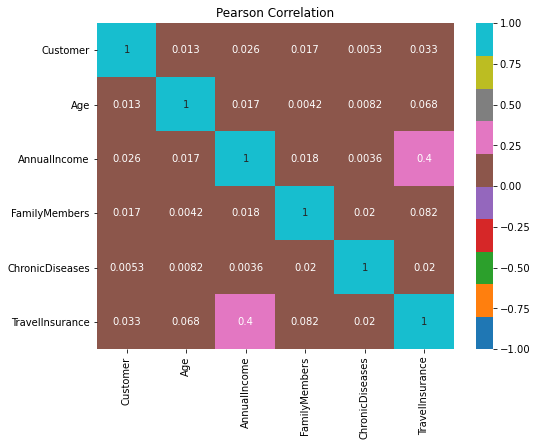

ChronicDiseases    0.019600
Customer           0.032576
Age                0.068138
FamilyMembers      0.081617
AnnualIncome       0.395549
TravelInsurance    1.000000
Name: TravelInsurance, dtype: float64


In [14]:
corr = train_df.corr(method='pearson').abs()

fig = plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='tab10', vmin=-1, vmax=+1)
plt.title('Pearson Correlation')
plt.show()

print (train_df.corr()['TravelInsurance'].abs().sort_values())

## Baseline

In this section we present a baseline based on a decision tree classifier.

Many of the attributes are binary, there are a couple of numeric attributes, we might be able to one-hot (e.g. family members), or event discretize (age and anual income), this will come more clearly after the EDA.

In [15]:
from sklearn.compose import make_column_transformer
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.linear_model import SGDClassifier

### Transform the columns into features

First we need to transform the columns into features. The type of features we use will have a direct impact on the final result. In this example we decided to discretize some numeric features and make a one hot encoding of others. The number of bins, what we use as a one hot encoding, etc, is all up to you to try it out.

In [16]:
transformer = make_column_transformer(
    (KBinsDiscretizer(n_bins=5, encode="ordinal", strategy="quantile"), ["Age", "AnnualIncome"]),
    (OneHotEncoder(categories="auto", dtype="int", handle_unknown="ignore"),
     ["Employment Type", "GraduateOrNot", "FamilyMembers", "FrequentFlyer", "EverTravelledAbroad"]),
    remainder="passthrough")

We transform the train and test data. In order to avoid overfitting is better to remove the `Customer` column and we don't want the `TravelInsurance` column as part of the attributes either.

In [17]:
# The data for training the model
X_train = transformer.fit_transform(train_df.drop(columns=["Customer", "TravelInsurance"]))
y_train = train_df["TravelInsurance"].values

# The test data is only for generating the submission
X_test = transformer.transform(test_df.drop(columns=["Customer"]))

### Decision Tree - Grid Search

We do a Grid Search for the Decision Tree (this can be replaced by a randomized search if the model is too complex).

In [18]:
search_params = {
    'criterion': ['gini', 'entropy'],
    'min_samples_leaf': [1, 2, 5],
    'max_depth': [3, 6, 10]
}
tree = DecisionTreeClassifier(random_state=42)
tree_clf = GridSearchCV(tree, search_params, cv=4, scoring='f1', n_jobs=-1)
tree_clf.fit(X_train, y_train)

best_tree_clf = tree_clf.best_estimator_

In [19]:
print(best_tree_clf)

DecisionTreeClassifier(criterion='entropy', max_depth=6, min_samples_leaf=5,
                       random_state=42)


### Check Results

We can print the results of the best estimator found on the whole training set (we could also set apart a validation set if we find it useful).

In [20]:
print(classification_report(y_train, best_tree_clf.predict(X_train)))

              precision    recall  f1-score   support

           0       0.81      0.96      0.88       958
           1       0.89      0.61      0.72       532

    accuracy                           0.83      1490
   macro avg       0.85      0.78      0.80      1490
weighted avg       0.84      0.83      0.82      1490



## Analizamos los resultados de aplicar diferentes modelos de aprendizaje

### SVM - Grid Search

In [21]:
params = {
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "gamma": ["auto", "scale"],
    "C":[1,10,20]
}

svm = SVC()
svm_clf = GridSearchCV(svm, params, cv=4, scoring='f1', n_jobs=-1)
svm_clf.fit(X_train, y_train)

best_svm = svm_clf.best_estimator_

In [22]:
print(best_svm)

SVC(C=10, gamma='auto', kernel='poly')


In [23]:
print(classification_report(y_train, best_svm.predict(X_train)))

              precision    recall  f1-score   support

           0       0.81      0.96      0.88       958
           1       0.90      0.61      0.73       532

    accuracy                           0.84      1490
   macro avg       0.86      0.78      0.80      1490
weighted avg       0.85      0.84      0.83      1490



No arrojo buenos resultados en competencia

### KNN

In [24]:
params = {
    "n_neighbors": [1,2,3,4,5,6,7,8,15,20],
    "weights": ["uniform", "distance"],
    "algorithm":["auto", "ball_tree", "kd_tree", "brute"]
}


knn = KNeighborsClassifier()
knn_clf= GridSearchCV(knn, params, cv=4, scoring='f1', n_jobs=-1)
knn_clf.fit(X_train, y_train)

best_knn = knn_clf.best_estimator_

In [25]:
print(best_knn)

KNeighborsClassifier(n_neighbors=7)


In [26]:
print(classification_report(y_train, best_knn.predict(X_train)))

              precision    recall  f1-score   support

           0       0.82      0.94      0.87       958
           1       0.85      0.62      0.72       532

    accuracy                           0.83      1490
   macro avg       0.84      0.78      0.80      1490
weighted avg       0.83      0.83      0.82      1490



No arrojo buenos resultados en competencia.

### KNN Radius -

In [27]:
params = {
    "weights": ["uniform", "distance"],
    "algorithm":["auto", "ball_tree", "kd_tree", "brute"],
    "outlier_label":["most_frequent"],
}

knnr = RadiusNeighborsClassifier()
knnr_clf= GridSearchCV(knnr, params, cv=9, scoring='f1', n_jobs=-1)
knnr_clf.fit(X_train, y_train)

best_knnr = knnr_clf.best_estimator_

In [28]:
print(best_knnr)

RadiusNeighborsClassifier(outlier_label='most_frequent', weights='distance')


In [29]:
print(classification_report(y_train, best_knnr.predict(X_train)))

              precision    recall  f1-score   support

           0       0.87      0.98      0.92       958
           1       0.95      0.74      0.83       532

    accuracy                           0.89      1490
   macro avg       0.91      0.86      0.88      1490
weighted avg       0.90      0.89      0.89      1490



Pensamos que este sería el mejor modelo. Se subio con parámetros 
RadiusNeighborsClassifier(outlier_label='most_frequent', weights='distance')
y dio 0,69 de score en la competencia.

### SGD Linear

In [30]:
# Selección de parámetros
params = {
    'loss': ['perceptron','hinge','log','squared_loss','epsilon_insensitive'],
    'penalty' : ['l2', 'l1', 'none'],
    'alpha' : [0.0001, 0.001, 0.01, 0.1],
    'random_state': [42],
    'learning_rate': ['optimal','constant','invscaling'],
    'eta0': [0.0001, 0.001, 0.01, 0.1]
}

sgdlinear = SGDClassifier()
sgdlinear_clf = GridSearchCV(sgdlinear, params, cv=9, scoring='f1', n_jobs=-1)
sgdlinear_clf.fit(X_train, y_train)

best_sgdlinear = sgdlinear_clf.best_estimator_

In [31]:
print(best_sgdlinear)

SGDClassifier(alpha=0.1, eta0=0.0001, loss='log', random_state=42)


In [32]:
print(classification_report(y_train, best_sgdlinear.predict(X_train)))

              precision    recall  f1-score   support

           0       0.77      0.96      0.85       958
           1       0.86      0.48      0.61       532

    accuracy                           0.79      1490
   macro avg       0.81      0.72      0.73      1490
weighted avg       0.80      0.79      0.77      1490



Este modelo no arrojo buenos resultados. 

## Random Forest

In [33]:
from sklearn.ensemble import RandomForestClassifier

In [34]:
# Selección de parámetros
params = {
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [1, 2, 5],
    'min_samples_leaf': [1, 2, 5],
    'max_depth': [3, 6, 10],
    'max_features': ['auto', 'sqrt', 'log2'],
}

rforest = RandomForestClassifier()
rforest_clf = GridSearchCV(rforest, params, cv=9, scoring='f1', n_jobs=-1)
rforest_clf.fit(X_train, y_train)

best_rforest = rforest_clf.best_estimator_

In [35]:
print(best_rforest)

RandomForestClassifier(max_depth=10, max_features='sqrt', min_samples_split=5)


In [36]:
print(classification_report(y_train, best_rforest.predict(X_train)))

              precision    recall  f1-score   support

           0       0.83      0.97      0.89       958
           1       0.91      0.64      0.75       532

    accuracy                           0.85      1490
   macro avg       0.87      0.80      0.82      1490
weighted avg       0.86      0.85      0.84      1490



### Generate the output

Generamos el output de este modelo, el que arrojó un 0.80 en la métrica F1 utilziada en la competencia KAGGLE 👌

In [37]:
test_id = test_df["Customer"]
test_pred = best_rforest.predict(X_test)

submission = pd.DataFrame(list(zip(test_id, test_pred)), columns=["Customer", "TravelInsurance"])
submission.to_csv("travel_insurance_submission.csv", header=True, index=False)

## PIPELINE - RF

In [62]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

params = {
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [1, 2, 5],
    'min_samples_leaf': [1, 2, 5],
    'max_depth': [3, 6, 10],
    'max_features': ['auto', 'sqrt', 'log2'],
}

rforest = RandomForestClassifier()
rforest_clf = make_pipeline(StandardScaler(), GridSearchCV(rforest, params, cv=9,scoring='f1',n_jobs=-1))
rforest_clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gridsearchcv',
                 GridSearchCV(cv=9, estimator=RandomForestClassifier(),
                              n_jobs=-1,
                              param_grid={'criterion': ['gini', 'entropy'],
                                          'max_depth': [3, 6, 10],
                                          'max_features': ['auto', 'sqrt',
                                                           'log2'],
                                          'min_samples_leaf': [1, 2, 5],
                                          'min_samples_split': [1, 2, 5]},
                              scoring='f1'))])

In [63]:
print(classification_report(y_train, rforest_clf.predict(X_train)))

              precision    recall  f1-score   support

           0       0.81      0.97      0.88       958
           1       0.92      0.59      0.72       532

    accuracy                           0.84      1490
   macro avg       0.87      0.78      0.80      1490
weighted avg       0.85      0.84      0.83      1490



### Generate the output

Generamos el output de este modelo, el que arrojó un 0.81 en la métrica F1 utilizada en la competencia KAGGLE ✅. 
### Decidimos dejar este modelo en la competencia.

In [40]:
test_id = test_df["Customer"]
test_pred = rforest_clf.predict(X_test)

submission = pd.DataFrame(list(zip(test_id, test_pred)), columns=["Customer", "TravelInsurance"])
submission.to_csv("travel_insurance_submission.csv", header=True, index=False)

## Naive Bayes (o gaussiannnb)

In [41]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold

In [42]:
# Selección de parámetros
params = {}
gaussNB = GaussianNB()

gaussNB_clf = GridSearchCV(gaussNB, params, cv=9, scoring='f1', n_jobs=-1)
gaussNB_clf.fit(X_train, y_train)

best_gaussNB = gaussNB_clf.best_estimator_

In [43]:
print(classification_report(y_train, best_gaussNB.predict(X_train)))

              precision    recall  f1-score   support

           0       0.77      0.83      0.80       958
           1       0.65      0.55      0.60       532

    accuracy                           0.73      1490
   macro avg       0.71      0.69      0.70      1490
weighted avg       0.73      0.73      0.73      1490



El modelo Naive Bayes no arrojo buenos resultados

## Logistic Regression

In [44]:
from sklearn.linear_model import LogisticRegression

# Selección de parámetros
params = {
    'penalty':['l1', 'l2', 'elasticnet', 'none'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}



Logreg = LogisticRegression()

Logreg_clf = GridSearchCV(Logreg, params, cv=9, scoring='f1', n_jobs=-1)
Logreg_clf.fit(X_train, y_train)

best_Logreg = Logreg_clf.best_estimator_


In [45]:
print(classification_report(y_train, best_Logreg.predict(X_train)))

              precision    recall  f1-score   support

           0       0.76      0.93      0.83       958
           1       0.78      0.47      0.59       532

    accuracy                           0.76      1490
   macro avg       0.77      0.70      0.71      1490
weighted avg       0.77      0.76      0.75      1490



El modelo Logistic Regression no arrojó buenos resultados.

# Modificación de Modelo con otro Scaler

Probamos realizar el trabajo aplicando un preprocesamiento diferente, el MinMaxScaler, pero los resultados no fueron buenos. 

In [46]:
from sklearn.preprocessing import MinMaxScaler

transformer = make_column_transformer(
    (MinMaxScaler(feature_range=(0,1)), ["Age", "AnnualIncome", "FamilyMembers"]),
    (OneHotEncoder(categories="auto", dtype="int", handle_unknown="ignore"),
     ["Employment Type", "GraduateOrNot", "FrequentFlyer", "EverTravelledAbroad"]),
    remainder="passthrough")

In [47]:
# The data for training the model
X_train = transformer.fit_transform(train_df.drop(columns=["Customer", "TravelInsurance"]))
y_train = train_df["TravelInsurance"].values

# The test data is only for generating the submission
X_test = transformer.transform(test_df.drop(columns=["Customer"]))

In [48]:
search_params = {
    'criterion': ['gini', 'entropy'],
    'min_samples_leaf': [1, 2, 5],
    'max_depth': [3, 6, 10]
}
tree = DecisionTreeClassifier(random_state=42)
tree_clf = GridSearchCV(tree, search_params, cv=4, scoring='f1', n_jobs=-1)
tree_clf.fit(X_train, y_train)

best_tree_clf = tree_clf.best_estimator_

In [49]:
print(best_tree_clf)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=5, random_state=42)


In [50]:
print(classification_report(y_train, best_tree_clf.predict(X_train)))

              precision    recall  f1-score   support

           0       0.83      0.96      0.89       958
           1       0.89      0.64      0.74       532

    accuracy                           0.84      1490
   macro avg       0.86      0.80      0.81      1490
weighted avg       0.85      0.84      0.83      1490



## Generate the output

The last thing we do is generating a file that should be *submitted* on kaggle

In [66]:
#test_id = test_df["Customer"]
#test_pred = best_rforest.predict(X_test)

#submission = pd.DataFrame(list(zip(test_id, test_pred)), columns=["Customer", "TravelInsurance"])
#submission.to_csv("travel_insurance_submission.csv", header=True, index=False)

# Conclusión

Ha sido un gran aprendizaje en cómo tratar un dataset en entorno real de competencia con pocos datos y cómo ir subsanando diferentes situaciones en el proceso de su realización. Analizamos los datos, los preprocesamos y aplicamos múltiples modelos al problema, decidiendo tomar el modelo Random Forest Classification como el que nos representó en competencia